In [1]:
import bz2
import os

In [2]:
from model import create_model

nn4_small2 = create_model()

/home/aneo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')
# for layer in nn4_small2_pretrained.layers:
#     print(layer, layer.trainable)

In [4]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
# print('type(metadata)', type(metadata))

jc_orig.shape (1280, 960, 3)
jc_orig[0, 0, 1] 242
b [(245, 502) (707, 965)]


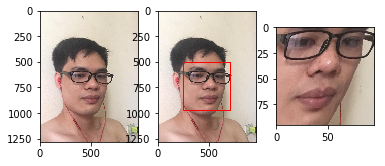

In [5]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
# for i in range(10, 20):
jc_orig = load_image('test_images/test_11.jpg')
# jc_orig = load_image(metadata[15].image_path())
print('jc_orig.shape', jc_orig.shape)
# print('jc_orig[0, 0, 1].dtype', jc_orig[0, 0, 1].dtype)
print('jc_orig[0, 0, 1]', jc_orig[0, 0, 1])

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)
bb1 = alignment.getAllFaceBoundingBoxes(jc_orig)
for b in bb1:
    print('b', b)
# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);
# print('metadata', metadata)

In [6]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [7]:
def align_image_for_test(img):
    bb = alignment.getLargestFaceBoundingBox(img)
    print('bb', bb)
    img_aligned = None
    has_face = False
    if bb != None:
        has_face = True
        img_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    return img_aligned, bb, has_face

In [8]:

def load_embedded(load_previous_data = False):
    if load_previous_data:
        embedded_load = np.load('embedded.npy')
        data = np.load('metadata.npy')
    else:
        data = load_metadata('images')
        np.save('metadata.npy', data)
        embedded_load = np.zeros((data.shape[0], 128))
        for i, m in enumerate(data):
            img = load_image(m.image_path())
            img = align_image(img)
            print(m.image_path())
            # scale RGB values to interval [0,1]
            img = (img / 255.).astype(np.float32)
            # obtain embedding vector for image
            embedded_load[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
#             print('type(embedded_load)', type(embedded_load))
        np.save('embedded.npy', embedded_load)
    return embedded_load, data
        
embedded, metadata = load_embedded()
# print('embedded.shape', embedded.shape)

images/quang_chuong/quang_chuong0004.jpg
images/quang_chuong/quang_chuong0006.jpg
images/quang_chuong/quang_chuong0005.jpg
images/quang_chuong/quang_chuong0003.jpg
images/quang_chuong/quang_chuong0001.jpg
images/quang_chuong/quang_chuong0002.jpg
images/Trinh_trong_trang/Trinh_trong_trang_0002.jpg
images/Trinh_trong_trang/Trinh_trong_trang_0003.jpg
images/Trinh_trong_trang/Trinh_trong_trang_0008.jpg
images/Trinh_trong_trang/Trinh_trong_trang_0006.jpg
images/Trinh_trong_trang/Trinh_trong_trang_0005.jpg
images/Trinh_trong_trang/Trinh_trong_trang_0010.jpg
images/Trinh_trong_trang/Trinh_trong_trang_0004.jpg
images/Trinh_trong_trang/Trinh_trong_trang_0009.jpg
images/Trinh_trong_trang/Trinh_trong_trang_0001.jpg
images/Trinh_trong_trang/Trinh_trong_trang_0007.jpg
images/Vu_Dinh_Qui/Vu_Dinh_Qui_0009.jpg
images/Vu_Dinh_Qui/Vu_Dinh_Qui_0006.jpg
images/Vu_Dinh_Qui/Vu_Dinh_Qui_0003.jpg
images/Vu_Dinh_Qui/Vu_Dinh_Qui_0008.jpg
images/Vu_Dinh_Qui/Vu_Dinh_Qui_0002.jpg


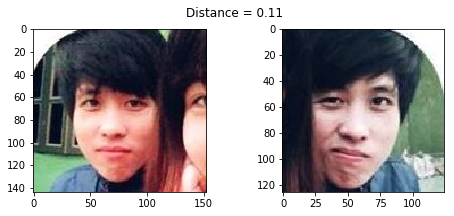

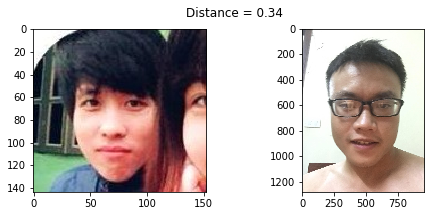

In [9]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle('Distance = {:.2f}'.format(distance(embedded[idx1], embedded[idx2])))
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

# print('metadata', metadata)
show_pair(1, 2)
show_pair(1, 13)

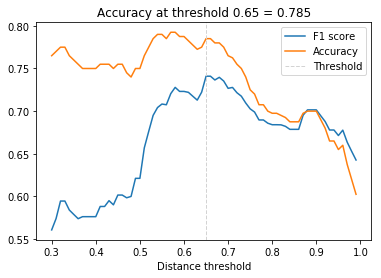

In [10]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise
# print(len(embedded))
num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Accuracy at threshold {:.2f} = {:.3f}'.format(opt_tau, opt_acc));
plt.xlabel('Distance threshold')
plt.legend();

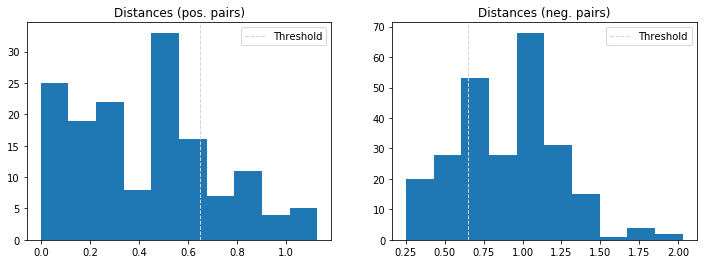

In [11]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0
# print('train_idx', train_idx)

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print('KNN accuracy = {}, SVM accuracy = {}'.format(acc_knn, acc_svc))

KNN accuracy = 1.0, SVM accuracy = 1.0


In [13]:
def make_prediction(example_image, print_img = False):
    img, bb, has_face = align_image_for_test(example_image)
#     print('bb', bb)
    # scale RGB values to interval [0,1]
    if print_img == True:
        print('example_image', example_image)
    example_identity = None
    if has_face == True:
        img = (img / 255.).astype(np.float32)
    #     img = (img / 255.)
        # obtain embedding vector for image
        embedded_for_test = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
        example_prediction = svc.predict([embedded_for_test])
        example_identity = encoder.inverse_transform(example_prediction)[0]
    return example_identity

In [14]:
def make_prediction_for_test(example_image, print_img = False):
#     img, bb, has_face = align_image_for_test(example_image)
#     print('bb', bb)
    # scale RGB values to interval [0,1]
    example_identity = None
#     if has_face == True:
    if print_img == True:
        print('example_image', example_image)
    img = (example_image / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded_for_test = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    example_prediction = svc.predict([embedded_for_test])
    example_identity = encoder.inverse_transform(example_prediction)[0]
    return example_identity

bb [(67, 68) (175, 175)]


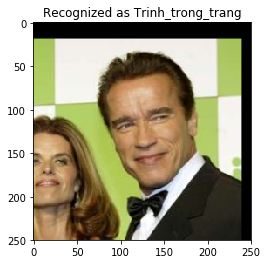

In [15]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 12

# example_image = load_image(metadata[test_idx][example_idx].image_path())
example_image = load_image('test_images/test_4.jpg')
# print('example_image.shape', example_image.shape)
# img = load_image(m.image_path())
example_identity = make_prediction(example_image, print_img = False)

plt.imshow(example_image)
plt.title('Recognized as {}'.format(example_identity));

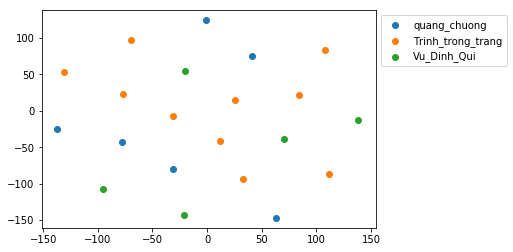

In [16]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

In [17]:
from imutils.video import VideoStream
from imutils import face_utils
from imutils.face_utils import FaceAligner
import imutils
import time
import cv2
import dlib
import os
import numpy as np

In [18]:
# video_capture = cv2.VideoCapture(1)

# while True:
#     # Capture frame-by-frame
#     ret, frame = video_capture.read()

#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     faces = alignment.getAllFaceBoundingBoxes(gray)

#     # Draw a rectangle around the faces
#     for (x, y, w, h) in faces:
#         cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

#     # Display the resulting frame
#     cv2.imshow('Video', frame)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # When everything is done, release the capture
# video_capture.release()
# cv2.destroyAllWindows()

In [ ]:
detector = dlib.get_frontal_face_detector()
vs = VideoStream()
vs.start()
time.sleep(2.0)
while True:
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
    frame = vs.read()
#     print(frame)
    frame = imutils.resize(frame, width=800)
    height, width = frame.shape[:2]
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
     # detect faces in the grayayscale frame
    rects = alignment.getAllFaceBoundingBoxes(gray_frame)
    for rect in rects:
#         faceAligned = fa.align(frame, gray_frame, rect)
#         faceAligned = cv2.cvtColor(faceAligned, cv2.COLOR_BGR2GRAY)
#         faceAligned = np.array(faceAligned)
#         faceAligned = faceAligned.astype('float32')
#         faceAligned /= 255.0
#         faceAligned = np.expand_dims([faceAligned], axis=4)
        # draw rect around face
        x, y, w, h = rect.left(), rect.top(), rect.width(), rect.height()
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 1)
        # draw person name
        jc_aligned = alignment.align(96, frame, rect, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
        result = make_prediction_for_test(jc_aligned, print_img = False)
#         print('result', result)
        cv2.putText(frame, result, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    cv2.imshow("Frame", frame)
cv2.destroyAllWindows()
vs.stop()
print(1)

In [ ]:
# vs.stop()